Experiement Sampling

In [3]:
import pandas as pd
import numpy as np
import faker

import scipy
import scipy.stats as stats
from scipy.stats import chi2
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.covariance import EmpiricalCovariance, MinCovDet
import matplotlib.pyplot as plt
import math

import researchpy as rp
import seaborn as sns

c:\Users\litia\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
c:\Users\litia\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
c:\Users\litia\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

Fake case: 

Every customer service agent has a customer rating. To reduce customer complaints and improve rating, the company plans to roll out a X hour training. Before scaling up the program, the company would like to run an experiement to see whether the training helps reduce customer complaints. 

Step 1 Create a dummy sample data set

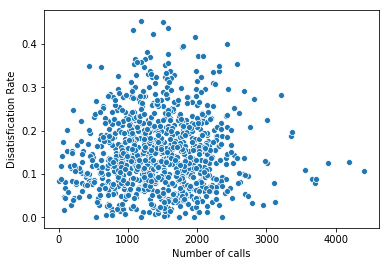

In [117]:
fake = faker.Faker()

# function to create a dataframe with fake values for our workers
def create_agents(n1, n2):

    def PosNormal(mean, sigma):
      x = np.random.normal(mean,sigma,1)
      return(x if x>=0 else PosNormal(mean,sigma))

    list_1 = [{'Agent ID': x + 1000
                , 'Agent Name': fake.name()
                , 'Number of calls': int(PosNormal(5, 1500)) # customer calls received between 0 and 2000, uniform dist
                , 'Disatisfication Rate': float(PosNormal(0.1,0.05)), # complaint rate between 0 and 50%, uniform dist.
                  } for x in range(n1)
                ]

    list_2 = [{'Agent ID': x + 1000 + n1
                , 'Agent Name': fake.name()
                , 'Number of calls': int(PosNormal(1500, 500)) # customer calls received between 0 and 2000, uniform dist
                , 'Disatisfication Rate': float(PosNormal(0.15,0.1)), # complaint rate between 0 and 50%, uniform dist.
                  } for x in range(n2)
                ]
        
    agents = list_1 + list_2 

    return agents

df_agent = pd.DataFrame(create_agents(n1 = 200, n2 = 800))

sns.scatterplot(data=df_agent, x="Number of calls", y="Disatisfication Rate")

In [118]:
print(df_agent.head().to_markdown())

|    |   Agent ID | Agent Name      |   Number of calls |   Disatisfication Rate |
|---:|-----------:|:----------------|------------------:|-----------------------:|
|  0 |       1000 | Joshua Herrera  |                88 |              0.0813228 |
|  1 |       1001 | Kenneth Shaw    |                11 |              0.0833123 |
|  2 |       1002 | Tara Green      |              1907 |              0.101386  |
|  3 |       1003 | Aaron Ross      |              2227 |              0.0909388 |
|  4 |       1004 | Makayla Nichols |              1402 |              0.108821  |


In [8]:
def calculateMahalanobis(y=None, data=None, cov=None):
  
    y_mu = y - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(y_mu, inv_covmat)
    mahal = np.dot(left, y_mu.T)
    return mahal.diagonal()

df_agent['Mahalanobis'] = calculateMahalanobis(y=df_agent[[
  'Number of calls', 'Disatisfication Rate']], data=df_agent[[
  'Number of calls', 'Disatisfication Rate']])

In [9]:
df_agent

,Agent ID,Agent Name,Number of calls,Disatisfication Rate,Mahalanobis
0,1000,Amber Hill,791,0.051597,2.075393
1,1001,Raymond Boyd,478,0.402953,1.882712
2,1002,Karen Moore,1853,0.009668,4.919014
3,1003,Julia Buckley,1568,0.028913,3.305569
4,1004,Renee Smith,119,0.106509,3.414003
...,...,...,...,...,...
995,1995,Mrs. Carol Yang,547,0.360122,1.167309
996,1996,Jeremy Harris,78,0.301644,2.709776
997,1997,Johnathan Haynes,1805,0.383503,2.671165
998,1998,Brandon Dominguez,1866,0.039466,4.343790


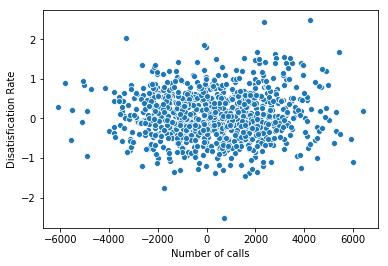

In [24]:
df_A = df_agent.sample(500)
df_B = df_agent[~df_agent['Agent ID'].isin(df_A['Agent ID'].to_list())]

In [25]:
df_A['Disatisfication Rate'].describe()

count    500.000000
mean       0.253039
std        0.143813
min        0.001170
25%        0.126749
50%        0.262126
75%        0.374767
max        0.499889
Name: Disatisfication Rate, dtype: float64

In [26]:
df_B['Disatisfication Rate'].describe()

count    500.000000
mean       0.255735
std        0.148368
min        0.000170
25%        0.128677
50%        0.259434
75%        0.385876
max        0.499605
Name: Disatisfication Rate, dtype: float64

In [15]:
np.average(df_A['Mahalanobis'])

2.1430258337765213

In [16]:
np.average(df_B['Mahalanobis'])

1.9903670613801827

In [17]:
np.average(df_A['Disatisfication Rate'])

0.24468082119936913

In [18]:
np.average(df_B['Disatisfication Rate'])

0.2548979236592364

In [20]:
np.average(df_A['Number of calls'])

878.54

In [21]:
np.average(df_B['Number of calls'])

1018.3273684210526

Design A/B Group based on Compliant Rate and Customer Calls

In [99]:
def sampling(df):
	
	# calculate Mahalanobis Distance
	def mashi_distance(x, y):

		X = np.vstack([x,y])		
		XT = X.T
		
		try:
			S = np.cov(X)
			SI = np.linalg.inv(S)
			n = XT.shape[0]
			d1 = []
			
			for i in range(0,n):
				for j in range(i+1, n):
					delta = XT[i] - XT[j]
					d = np.sqrt(np.dot(np.dot(delta, SI), delta.T))
					d1.append(d)

		except:
			d1 = [0]
		
		return d1
					
	agent_cnt = len(df_agent.index)
	n1 = math.floor(agent_cnt / 2)
	n2 = n1	
	
	count = 0
	distance1 = [3]
	distance2 = [3]
	
	while count < 100:
		if sum(distance1) / len(distance1) < 1.5 and sum(distance2) / len(distance2) < 1.5:
			break
		else:
			count = count + 1
			df1 = df.sample(n = n1)
			df2 = df[~df.index.isin(df1.index)]
			df2 = df2.sample(n = n2)
			
			x_list1 = df1['Compliant Rate'].to_list()
			y_list1 = df2['Compliant Rate'].to_list()
		
			x_list2 = df1['Customer Calls'].to_list()
			y_list2 = df2['Customer Calls'].to_list()
			
			distance1 = mashi_distance(x_list1, y_list1)
			distance2 = mashi_distance(x_list2, y_list2)
	   
	print(count)
	
	return df1, df2

df_treatment = pd.DataFrame()
df_control = pd.DataFrame()
df_treatment, df_control = sampling(df_agent)


100


In [114]:
df_treatment.reset_index(drop = True, inplace = True)
df_control.reset_index(drop = True, inplace = True)
df_treatment['Group'] = 'Treatment'
df_control['Group'] = 'Control'
df_AB = pd.concat([df_treatment, df_control])

In [113]:
df_treatment.sort_values(by = 'Compliant Rate', ascending = True, inplace = True)
df_control.sort_values(by = 'Compliant Rate', ascending = True, inplace = True)

In [101]:
df_AB.groupby('Group')['Compliant Rate'].describe()

,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
Control,500.0,0.257735,0.140889,0.000732,0.139091,0.251186,0.379196,0.498896
Treatment,500.0,0.254600,0.141401,0.000830,0.132990,0.258347,0.370866,0.499110


In [102]:
df_AB.groupby('Group')['Customer Calls'].describe()

,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
Control,500.0,996.548,602.216301,1.0,427.50,1020.5,1535.50,1999.0
Treatment,500.0,975.122,579.293332,4.0,485.75,960.5,1473.25,1999.0


In [103]:
df_AB.groupby('Group')['Compliant Rate'].apply(rp.summary_cont)

,,Variable,N,Mean,SD,SE,95% Conf.,Interval
Group,,,,,,,,
Control,0,Control,500.0,0.2577,0.1409,0.0063,0.2454,0.2701
Treatment,0,Treatment,500.0,0.2546,0.1414,0.0063,0.2422,0.2670


Check Normality

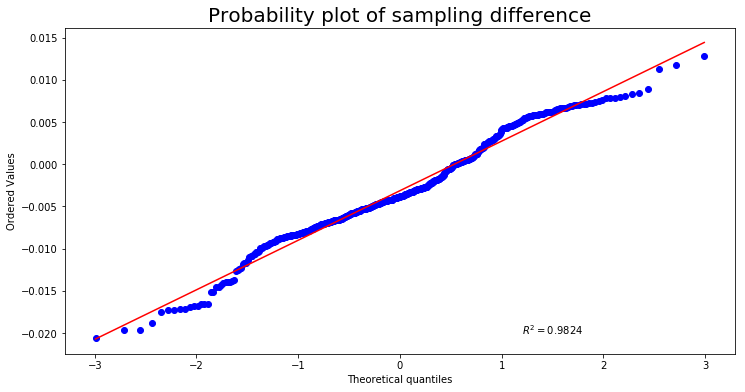

In [115]:
sampling_difference = df_treatment['Compliant Rate'].values - \
                    df_control['Compliant Rate'].values

# sampling_difference2 = df_treatment['Compliant Rate (Log)'].values - \
#                     df_control['Compliant Rate (Log)'].values

fig = plt.figure(figsize= (12, 6))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(sampling_difference, plot= plt, rvalue= True)
ax.set_title("Probability plot of sampling difference", fontsize= 20)
ax.set

plt.show()

In [116]:
stats.shapiro(sampling_difference) # data is non normal since p value < 0.05

(0.9818898439407349, 7.004032340773847e-06)

In [117]:
stats.normaltest(sampling_difference)

NormaltestResult(statistic=0.13535414697201242, pvalue=0.9345622197734095)

In [118]:
stats.ks_2samp(df_treatment['Compliant Rate'], df_control['Compliant Rate'])

Ks_2sampResult(statistic=0.03600000000000003, pvalue=0.8969819972425297)

In [91]:
# transform data
df_treatment['Compliant Rate (Log)'] = np.sqrt(df_treatment['Compliant Rate'])
df_control['Compliant Rate (Log)'] = np.sqrt(df_control['Compliant Rate'])
df_AB['Compliant Rate (Log)'] = np.sqrt(df_AB['Compliant Rate'])

In [92]:
stats.ks_2samp(df_treatment['Compliant Rate (Log)'], df_control['Compliant Rate (Log)'])

Ks_2sampResult(statistic=0.1100000000000001, pvalue=0.004277444915243255)

HOMOGENEITY OF VARIANCES

In [119]:
stats.levene(df_treatment['Compliant Rate'], df_control['Compliant Rate'])

LeveneResult(statistic=0.014140321276582749, pvalue=0.9053681471756329)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D199D467F0>,
      dtype=object)

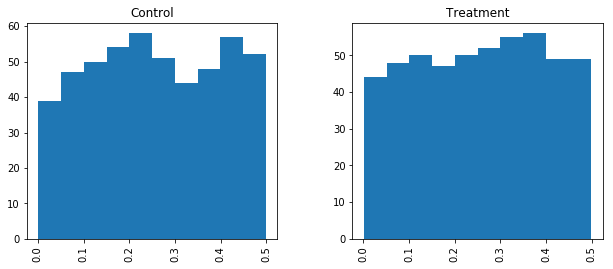

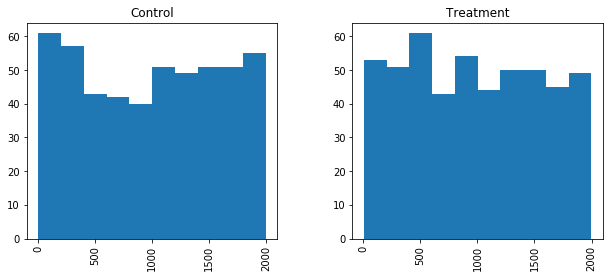

In [120]:
df_AB.hist(by='Group',column='Compliant Rate', figsize=[10, 4])
df_AB.hist(by='Group',column='Customer Calls', figsize=[10, 4])

In [121]:
scipy.stats.ttest_ind(df_treatment['Compliant Rate'], df_control['Compliant Rate'])

Ttest_indResult(statistic=-0.3511547655823801, pvalue=0.7255463595369571)

In [122]:
stats.bartlett(df_treatment['Compliant Rate'],
               df_control['Compliant Rate'])

BartlettResult(statistic=0.006539613283687296, pvalue=0.9355470279233566)

In [123]:
rp.ttest(group1= df_treatment['Compliant Rate'], group1_name= "Treatment",
         group2= df_control['Compliant Rate'], group2_name= "Control")

(    Variable       N      Mean        SD        SE  95% Conf.  Interval
 0  Treatment   500.0  0.254600  0.141401  0.006324   0.242176  0.267025
 1    Control   500.0  0.257735  0.140889  0.006301   0.245356  0.270114
 2   combined  1000.0  0.256168  0.141083  0.004461   0.247413  0.264923,
                     Independent t-test   results
 0  Difference (Treatment - Control) =    -0.0031
 1                Degrees of freedom =   998.0000
 2                                 t =    -0.3512
 3             Two side test p value =     0.7255
 4            Difference < 0 p value =     0.3628
 5            Difference > 0 p value =     0.6372
 6                         Cohen's d =    -0.0222
 7                         Hedge's g =    -0.0222
 8                    Glass's delta1 =    -0.0222
 9                  Point-Biserial r =    -0.0111)

Control and treatment groups have similar mean and stdev, p value of t-test is 0.7255 > 0.5, indicating the mean of two groups have no statistical significant difference.